## NN(RNN) onset detection

Supervisor: Peter Jancovic

Student: Yuxuan Yang 1976844


In [1]:
from __future__ import print_function, division

import numpy as np
import tensorflow as tf
import keras
import madmom
import pickle
import warnings

Using TensorFlow backend.


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

RNN training is often faster if run on CPU only, thus disabling GPU support:

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [7]:
FPS = 100
ONSET_PATH = 'D:/projectRESEARCH/CNN/Aut_Week8/'

### File Input

- `audio/` contains all audio files,
- `annotations/` contains various annotations, e.g. onsets, beats, etc., each of them in a separate sub-directory,
- `splits/` contains predefined splits.



In [8]:
class Dataset(object):
    
    def __init__(self, path, audio_suffix='.wav', annotation_suffix='.onsets'):
        self.path = path
        # populate lists containing audio and annotation files
        audio_files = madmom.utils.search_files(self.path + '/audio', audio_suffix)
        annotation_files = madmom.utils.search_files(self.path + '/annotations', annotation_suffix, recursion_depth=1)
        # match annotation to audio files
        self.files = []
        self.audio_files = []
        self.annotation_files = []
        for annotation_file in annotation_files:
            # search matching audio file
            matches = madmom.utils.match_file(annotation_file, audio_files, suffix=annotation_suffix, match_suffix=audio_suffix)
            if len(matches) == 1:
                audio_file = matches[0]
                self.audio_files.append(audio_file)
                self.annotation_files.append(annotation_file)
                # save the base name
                self.files.append(os.path.basename(annotation_file[:-len(annotation_suffix)]))
            else:
                warnings.warn('skipping %s, no audio file found' % annotation_file)
                             
        
    def load_splits(self, path=None, fold_suffix='.fold'):
        path = path if path is not None else self.path + '/splits'
        self.split_files = madmom.utils.search_files(path, fold_suffix, recursion_depth=1)
        # populate folds
        self.folds = []
        for i, split_file in enumerate(self.split_files):
            fold_idx = []
            with open(split_file) as f:
                for file in f:
                    file = file.strip()
                    # get matching file idx
                    try:
                        idx = self.files.index(file)
                        fold_idx.append(idx)
                    except ValueError:
                        # file could be not available, e.g. in Ballrom set a few duplicates were found
                        warnings.warn('no matching audio/annotation files: %s' % file)
                        continue
            # set indices for fold
            self.folds.append(np.array(fold_idx))
            
    def pre_process(self, pre_processor):
        self.x = [pre_processor(file) for file in self.audio_files]
        
    def load_annoatations(self, widen=None):
        self.annotations = [madmom.io.load_onsets(file) for file in self.annotation_files]


In [9]:
onsets_db = Dataset(ONSET_PATH, audio_suffix='.wav')
onsets_db.load_annoatations()
onsets_db.load_splits()

### Feature pre-processing


In [10]:
from madmom.processors import ParallelProcessor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor, SpectrogramDifferenceProcessor
        
# define pre-processor
class OnsetPreProcessor(SequentialProcessor):

    def __init__(self, frame_sizes=[1024, 2048, 4096], num_bands=[3, 6, 12]):
        # resample to a fixed sample rate in order to get always the same number of filter bins
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # process multi-resolution spec & diff in parallel
        multi = ParallelProcessor([])
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            # split audio signal in overlapping frames
            frames = FramedSignalProcessor(frame_size=frame_size)
            # compute STFT
            stft = ShortTimeFourierTransformProcessor()
            # filter the magnitudes
            filt = FilteredSpectrogramProcessor(num_bands=num_bands)
            # scale them logarithmically
            spec = LogarithmicSpectrogramProcessor()
            # stack positive differences
            diff = SpectrogramDifferenceProcessor(positive_diffs=True, stack_diffs=np.hstack)
            # process each frame size with spec and diff sequentially
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        # instantiate a SequentialProcessor
        super(OnsetPreProcessor, self).__init__((sig, multi, np.hstack))

# create a callable pre-processor
pp = OnsetPreProcessor()

In [11]:
onsets_db.pre_process(pp)

### Sequence handling for NN training


In [12]:
from keras.utils import Sequence

class DataSequence(Sequence):
    
    mask_value = -999  # only needed for batch sizes > 1

    def __init__(self, x, y, batch_size=1, max_seq_length=None, fps=FPS):
        self.x = x
        self.y = [madmom.utils.quantize_events(o, fps=fps, length=len(d))
                  for o, d in zip(y, self.x)]
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        # determine which sequence(s) to use
        x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # pad them if needed
        if self.batch_size > 1:
            x = keras.preprocessing.sequence.pad_sequences(
                x, maxlen=self.max_seq_length, dtype=np.float32, truncating='post', value=self.mask_value)
            y = keras.preprocessing.sequence.pad_sequences(
                y, maxlen=self.max_seq_length, dtype=np.int32, truncating='post', value=self.mask_value)
        return np.array(x), np.array(y)[..., np.newaxis]
    

In [13]:
class Fold(object):
    
    def __init__(self, folds, fold):
        self.folds = folds
        self.fold = fold
        
    @property
    def test(self):
        # fold N for testing
        return np.unique(self.folds[self.fold])
        
    @property
    def val(self):
        # fold N+1 for validation
        return np.unique(self.folds[(self.fold + 1) % len(self.folds)])
        
    @property
    def train(self):
        # all remaining folds for training
        train = np.hstack((onsets_db.folds))
        train = np.setdiff1d(train, self.val)
        train = np.setdiff1d(train, self.test)
        return train
            

## Train network

First define which sequences are used for training and validation, leave the files for testing untouched.

In [14]:
basedir = 'models/onsets/'

In [15]:
lr = 0.01
num_fold = 0

fold = Fold(onsets_db.folds, num_fold)

train = DataSequence([onsets_db.x[i] for i in fold.train],
                     [onsets_db.annotations[i] for i in fold.train],
                      batch_size=1, max_seq_length=60 * FPS)
                             
val = DataSequence([onsets_db.x[i] for i in fold.val],
                   [onsets_db.annotations[i] for i in fold.val],
                    batch_size=1, max_seq_length=60 * FPS)

In [18]:
example = 'Study5'
example_idx = onsets_db.files.index(example)

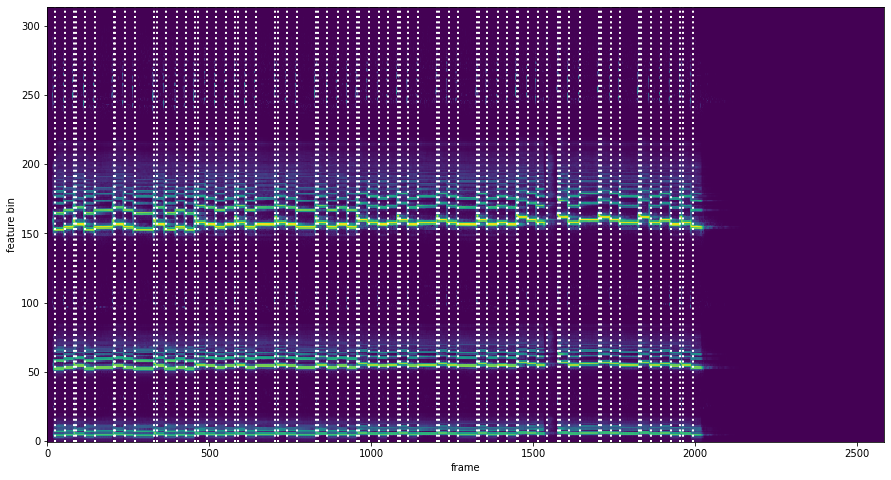

In [21]:
plt.imshow(onsets_db.x[example_idx].T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('feature bin')
for ann in onsets_db.annotations[example_idx]:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

In [22]:
from keras.models import Sequential
from keras.layers import Input, SimpleRNN, Bidirectional, Masking, LSTM, Dense

In [23]:
model = Sequential()
model.add(Masking(input_shape=(None, train[0][0].shape[-1]), mask_value=train.mask_value))
model.add(Bidirectional(SimpleRNN(units=25, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=25, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(units=25, return_sequences=True)))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.SGD(lr=lr, clipvalue=5, momentum=0.9),
              metrics=['binary_accuracy'])

In [24]:
verbose=0
name = '%s/lr_%s/fold_%s/' % (basedir, str(lr).replace('.', ''), str(fold.fold))

mca = keras.callbacks.ModelCheckpoint(name + 'model_{epoch:02d}.h5', monitor='loss', save_best_only=False, verbose=verbose)
mcb = keras.callbacks.ModelCheckpoint(name + 'model_best.h5', monitor='loss', save_best_only=True, verbose=verbose)
mcv = keras.callbacks.ModelCheckpoint(name + 'model_best_val.h5', monitor='val_loss', save_best_only=True, verbose=verbose)
es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=verbose)
tb = keras.callbacks.TensorBoard(log_dir=name + 'logs', write_graph=True, write_images=True)

In [ ]:
history = model.fit_generator(train, steps_per_epoch=len(train), epochs=100, shuffle=True,
                              validation_data=val, validation_steps=len(val),
                              callbacks=[mca, mcb, mcv, es, tb])
model.save(name + 'model_final.h5')

Epoch 1/200
239/239 [==============================] - 182s 762ms/step - loss: 0.1841 - binary_accuracy: 0.9485 - val_loss: 0.1575 - val_binary_accuracy: 0.9521
Epoch 2/200
 19/239 [=>............................] - ETA: 2:33 - loss: 0.1645 - binary_accuracy: 0.9508